In [113]:
# Libraries
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from IPython.core.interactiveshell import InteractiveShell

# Notebook Settings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read data
We requested historical wheat yield and harvested area data from the [Brazilian Institute of Geography and Statistics](https://sidra.ibge.gov.br/tabela/1612) for every wheat-cultivating municipality in the three southern states of Brazil: Rio Grande do Sul, Paraná, and Santa Catarina. These states are responsible for roughly [90%](https://www.conab.gov.br/info-agro/safras/serie-historica-das-safras/itemlist/category/913-trigo) of Brazilian wheat production. There are 584 municipalities.

Wheat production in the southern states and whole Brazil:
<img src="southvsrest.png" width="500"/>

In [114]:
yield_by_municipality = pd.read_csv("Data/Wheat/yield_by_year_and_municipality.csv") # 1993-2019
harvested_area_by_municipality = pd.read_csv("Data/Wheat/harvested_area_by_year_and_municipality.csv") # 1990-2019

### 2. Calculate National Wheat Yield
When we say *national wheat yield* in this notebook, we actually talk about wheat yield in the southern municipalities that are most relevant for Brazilian wheat production. The national wheat yield in year *j* is the sum of yields weighted by harvested area of each municipality *i*.

<h3 align="center">$Yield = \Large\frac{\sum_{i=1}^{N=584} HarvestedArea_{ij}*Yield_{ij}}{\sum_{i=1}^{N=584}HarvestedArea_{ij}}$<h3/>

In [115]:
national_yield = pd.DataFrame((yield_by_municipality.set_index(["code", "zone"]) 
                               * harvested_area_by_municipality.set_index(["code", "zone"])).sum() 
                               / harvested_area_by_municipality.set_index(["code", "zone"]).sum(), columns=["yield"])

For national wheat yield we only need data from 1993 until 2016, so that the crop data matches the available data from the seasonal climate models (other notebook).

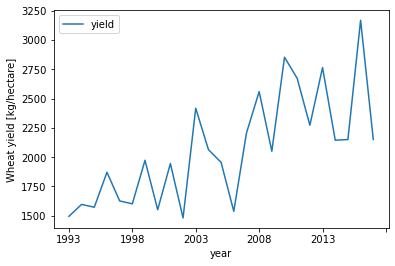

In [116]:
national_yield = np.round(national_yield.iloc[3:].reset_index().rename(columns={"index":"year"}), 2) # from 1993 onwards
national_yield = national_yield.loc[national_yield["year"].astype(int) <= 2017].reset_index(drop=True) # until 2016
ax = national_yield.plot("year", "yield");
ax.set_ylabel("Wheat yield [kg/hectare]");

### 3. Calculate Wheat Yield by Group

Based on the findings of Nóia Júnior et al. ([2021](https://iopscience.iop.org/article/10.1088/1748-9326/ac26f3)), we model wheat yield for agro-climatic homogeneous zones, which are groups of municipalities that show similar inter-annual wheat yield variabilities. Nóia Júnior et al. identified four of these groups. We will develop a climate-based wheat yield estimation model for each group independently. Data from the weather station in the municipality whose wheat yield is closest to the zone's wheat yield is used. The logic of aggregation is the same as for national wheat yield, only now we group by (and distinguish) by zones.
<img src="homogeneous_groups.png" width="350"/>

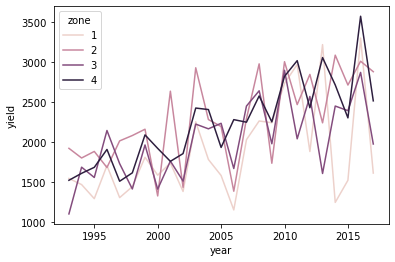

In [117]:
yield_by_group = ((yield_by_municipality.set_index(["code", "zone"]) 
                  * harvested_area_by_municipality.set_index(["code", "zone"]))
                  .groupby(["zone"])
                  .sum()) / (harvested_area_by_municipality
                             .set_index(["code", "zone"])
                             .groupby(["zone"])
                             .sum())
yield_by_group = yield_by_group.stack().reset_index().rename({"level_1":"year", 0:"yield"}, axis=1)
yield_by_group = (np.round(yield_by_group.loc[yield_by_group["year"].astype(int).isin(list(range(1993,2018)))]
                           .reset_index(drop=True), 2))
sns.lineplot(data=yield_by_group.astype(int), x="year", y="yield", hue="zone");

### 4. Detrend Wheat Yield Data

#### 4.1 By Group
Our model will be used to explain climate-induced wheat yield variabilities. Trends that arise through cultivar improvement or optimized crop management will not be the focus of this study. Therefore, we need to detrend the data. Our approach is to lift historical yield observations to the current level of technology, which is indicated by the wheat yield in 2017. We assume a linear growth of yield from 1993 to 2017. To trend-correct the yield for a given year, we estimate a slope using the yield of all other years. This slope indicates the average growth of yield from one year to another based on technological progress. We trend-correct all years from 1993 to 2016. 

$TrendCorrectedYield_y = yield_y + (slope * (2017 - year_y))$

In [123]:
def detrend_yield_by_group(df):
    df = df.copy()
    li = []
    for group in [1, 2, 3, 4]:
        for year in list(range(1993,2017)):
            group_yield = df.loc[(df["zone"] == group)].copy().reset_index(drop=True)
            yields_to_calculate_trend = group_yield.loc[group_yield["year"].astype(int) != year].copy().reset_index(drop=True)
            yield_to_be_adjusted = group_yield.loc[group_yield["year"].astype(int) == year].copy().reset_index(drop=True)
            reg = LinearRegression()
            slope_cv = reg.fit(yields_to_calculate_trend["year"].values.reshape(-1,1), yields_to_calculate_trend["yield"]).coef_[0]
            yield_to_be_adjusted["yield_detrended"] = yield_to_be_adjusted["yield"] + (slope_cv * (2017 - yield_to_be_adjusted["year"].astype(int)))
            li.append(yield_to_be_adjusted)

    df_cv = (pd
             .concat(li, axis=0, ignore_index=False)
             .sort_values(by=["zone", "year"])
             .reset_index(drop=True)
             .drop(["yield"], axis=1)
             .rename(columns={"yield_detrended":"yield"}))
        
    return df_cv

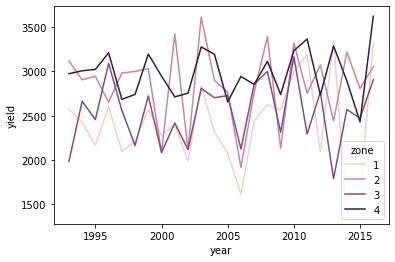

In [128]:
yield_by_group_detrended = detrend_yield_by_group(yield_by_group)
sns.lineplot(data=yield_by_group_detrended.loc[yield_by_group_detrended["year"].astype(int) > 1992].astype(int), x="year", y="yield", hue="zone");
#plt.savefig("detrended_yield_by_group.svg")

In [129]:
yield_by_group_detrended.to_csv("Data/Wheat/yield_by_group_detrended.csv", index=False)

#### 4.2 National

In [141]:
def detrend_national_yield(df):
    df = df.copy()
    li=[]
    for year in list(range(1993,2017)):
        yields_to_calculate_trend = df.loc[df["year"].astype(int) != year].copy().reset_index(drop=True)
        yield_to_be_adjusted = df.loc[df["year"].astype(int) == year].copy().reset_index(drop=True)
        reg = LinearRegression()
        slope_cv = reg.fit(yields_to_calculate_trend["year"].values.reshape(-1,1), yields_to_calculate_trend["yield"]).coef_[0]

        yield_to_be_adjusted["yield_detrended"] = yield_to_be_adjusted["yield"] + (slope_cv * (2017 - yield_to_be_adjusted["year"].astype(int)))
        li.append(yield_to_be_adjusted)
        
    df_cv = (pd
             .concat(li, axis=0, ignore_index=False)
             .reset_index(drop=True)
             .drop(["yield"], axis=1)
             .rename(columns={"yield_detrended":"yield"}))
    
    return df_cv

<AxesSubplot:xlabel='year', ylabel='yield'>

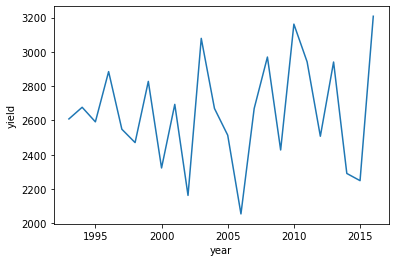

In [145]:
national_yield_detrended = detrend_national_yield(national_yield)
sns.lineplot(data=national_yield_detrended.astype(int), x="year", y="yield");
plt.savefig("detrended_national_yield.svg")

In [146]:
national_yield_detrended.to_csv("Data/Wheat/national_yield_detrended.csv", index=False)

### 5. Harvested Area
Harvested area by municipality also needs to be aggregated on group level. We first sum up and then compute the relative contribution of each group to total harvested area in this year.

In [158]:
ha_grouped = harvested_area_by_municipality.groupby("zone").sum().stack().reset_index().rename({"level_1":"year", 0:"area"}, axis=1).iloc[1:].reset_index(drop=True)
ha_grouped['relative area'] = ha_grouped['area'] / ha_grouped.groupby('year')['area'].transform('sum')
ha_grouped = np.round(ha_grouped.loc[ha_grouped["year"] != "code"].reset_index(drop=True), 2)
ha_grouped.head(2)

,zone,year,area,relative area
0,1,1990,1009412.0,0.44
1,1,1991,674580.0,0.35


<AxesSubplot:xlabel='year', ylabel='relative area'>

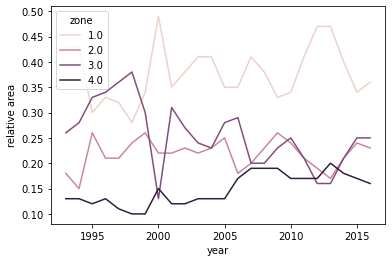

In [159]:
sns.lineplot(data=ha_grouped.loc[ha_grouped["year"].astype(int).isin(list(range(1993,2017)))].astype(float), x="year", y="relative area", hue="zone")
plt.savefig("harvested_area_by_group.svg")

#### Forward Validation
We will train four separate wheat yield estimation models. One for each agro-climatic homogeneous zone. To obtain an estimation on national level, the yield estimations are extrapolated using the relative harvested area of the corresponding group. However, harvested area will not be known at the moment the model makes its estimations. Hence, we need to extrapolate the yield estimations to national level using harvested area estimations. Using [forward validation](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/), we validate different window sizes, e.g. the harvested area estimation for year *y* is the harvested area from the *n* previous year.

In [160]:
def forward_validation(df, previous_days=1):
    sum_ = 0
    for group in [1, 2, 3, 4]:
        sum_group = 0
        for i in range(3, 27):
            sum_group += abs(df.loc[df["zone"] == group, "relative area"].values[i-previous_days:i] 
                             - df.loc[df["zone"] == group, "relative area"].values[i])
        sum_group /= 24
        sum_ += sum_group[0]
    sum_ /= 4
    sum_ = np.round(sum_, 6)
    return sum_

In [161]:
forward_validation(ha_grouped, 1)
forward_validation(ha_grouped, 2)
forward_validation(ha_grouped, 3)

0.034792

0.050208

0.046042

The **mean absolute difference** between harvested area ground truth and estimation is lowest for window size 1. Meaning that the estimation of harvested area for year *y* is the harvested area from the previous year. Now, we perform the estimations:

<AxesSubplot:xlabel='year', ylabel='area'>

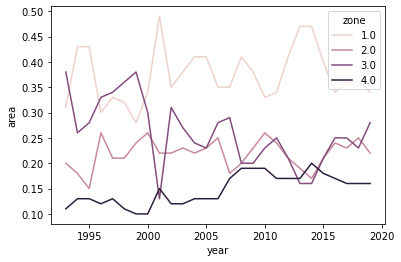

In [162]:
ha_grouped["area"] = ha_grouped["relative area"].shift(1)
ha_grouped = np.round(ha_grouped.loc[ha_grouped["year"].isin(["code", '1990', '1991', '1992']) == False, ["zone", "year", "area"]].reset_index(drop=True), 2)
sns.lineplot(data=ha_grouped.astype(float), x="year", y="area", hue="zone")

In [163]:
ha_grouped.to_csv("Data/Wheat/harvested_area_estimates_by_group.csv", index=False)